In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# For 1 | Preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, make_pipeline # Same, but with the latter it is not necessary to name estimator and transformer
#from imblearn.pipeline import Pipeline as Imb_Pipe
from sklearn.compose import ColumnTransformer

# For 2 | Predictive Modeling: Classification ("occupancy_class")
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.metrics import r2_score, make_scorer, fbeta_score, accuracy_score, confusion_matrix, f1_score, precision_recall_curve, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from xgboost import XGBClassifier
import statsmodels.api as sm

# For 3 | Predictive Modeling: Regression ("price")
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor

In [2]:
# Import data_engineered
data = pd.read_csv("data_engineered.csv")

In [3]:
# Set global variables
test_size = 0.3
random_state = 100

# Preprocessing (Train/Test Split and Pipeline)

**Preprocessing pipeline**

In [4]:
# Creating list for categorical predictors/features (used in "Scaling with Preprocessing Pipeline") 
cat_features = list(data.columns[data.dtypes==object])
cat_features

['amenities',
 'bed_type',
 'cancellation_policy',
 'cleaning_fee',
 'description',
 'experiences_offered',
 'extra_people',
 'has_availability',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_is_superhost',
 'host_location',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'house_rules',
 'instant_bookable',
 'is_business_travel_ready',
 'is_location_exact',
 'last_scraped',
 'market',
 'name',
 'property_type',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'security_deposit',
 'space',
 'summary']

In [5]:
# TEMP: Removing all categorical columns
data.drop(cat_features, axis=1, inplace=True)
cat_features = list(data.columns[data.dtypes==object])
cat_features

[]

In [6]:
# TEMP: Removing all with price >$1.000
data = data[data.price <= 1000]

In [7]:
# Creating list for numerical predictors/features (removing target column, used in "Scaling with Preprocessing Pipeline")
num_features = list(data.columns[data.dtypes!=object])
num_features.remove('price')
num_features

['accommodates',
 'availability_365',
 'bathrooms',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'guests_included',
 'host_id',
 'host_listings_count',
 'id',
 'latitude',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [8]:
# Pipeline using Pipeline
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [9]:
data.shape

(99949, 24)

In [10]:
data.head(2)

,accommodates,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,guests_included,host_id,host_listings_count,id,...,number_of_reviews,number_of_reviews_ltm,price,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,2,156,1.0,1.0,1.0,1,1,34596621,2.0,15107151,...,10,NaN,45.0,10.0,10.0,10.0,10.0,10.0,10.0,0.53
1,2,5,1.0,1.0,2.0,3,1,110413588,3.0,17260587,...,6,NaN,30.0,10.0,10.0,10.0,10.0,9.0,10.0,0.50


**Train/test split**

In [11]:
# Define predictors and target variable
X = data.drop(["price"], axis=1)
y = data["price"]

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,
                                                        random_state=random_state,
                                                        shuffle=True)
#                                                   stratify=y) # Use stratify=y if labels are inbalanced (e.g. most wines are 5 or 6; check with value_counts()!)

In [13]:
# Saving preprocessed X_train and X_test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

**Dummy Classifier (to establish baseline)**

In [14]:
# Set dummy classifier
#dum_clf = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
#y_pred_dum_clf = dum_clf.predict(X_test)

#Distribution of y test
#print('y actual : \n' +  str(y_test_full.value_counts()))

#Distribution of y predicted
#print('y predicted : \n' + str(pd.Series(y_pred_dum_clf).value_counts()))

In [15]:
X_train_prep.shape

(69964, 23)

# Predictive Modeling: Classification ("occupancy_class")

# Predictive Modeling: Regression ("price")

## Linear regression (OLS)

**Apply linear regression**

In [16]:
# Transform X_train_prep and y_train to required format
X_train_prep_ols = X_train_prep
X_train_prep_ols = sm.add_constant(X_train_prep_ols)
y_train_ols = np.asarray(y_train)

In [17]:
# Initiate and fit model
reg_ols = sm.OLS(y_train_ols, X_train_prep_ols).fit()

In [18]:
# Print model summary
reg_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     1239.
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:12:59   Log-Likelihood:            -3.7372e+05
No. Observations:               69964   AIC:                         7.475e+05
Df Residuals:                   69940   BIC:                         7.477e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.3941      0.191    326.502      0.000      62.020      62.769
x1            21.0873      0.338     62.306      0.000      20.424      21.751
x2             9.1966      0.208     44.134      0.000       8.788       9.605
x3             5.5507      0.203     27.313      0.000       5.152       5.949
x4             8.8266      0.262     33.743      0.000       8.314       9.339
x5            -3.9323      0.325    -12.096      0.000      -4.569      -3.295
x6            -0.5325      0.207     -2.567      0.010      -0.939      -0.126
x7             4.3138      0.210     20.556      0.000       3.902       4.725
x8             2.0660      0.231      8.937      0.000       1.613       2.519
x9             0.7345      0.195      3.774      0.000       0.353       1.116
x10            3.2221      0.255     12.635      0.000       2.722       3.722
x11            2.0491      0.193     10.620      0.000       1.671       2.427
x12           -0.9185      0.193     -4.755      0.000      -1.297      -0.540
x13           -0.1253      0.191     -0.656      0.512      -0.500       0.249
x14           -1.6909      0.194     -8.727      0.000      -2.071      -1.311
x15           -0.6690      0.319     -2.100      0.036      -1.293      -0.045
x16           -0.1548      0.325     -0.477      0.633      -0.791       0.481
x17           -0.1613      0.271     -0.596      0.551      -0.692       0.369
x18           -0.2410      0.258     -0.934      0.350      -0.747       0.265
x19            5.3745      0.249     21.607      0.000       4.887       5.862
x20            0.2907      0.266      1.094      0.274      -0.230       0.811
x21            4.6857      0.222     21.069      0.000       4.250       5.122
x22           -4.7144      0.278    -16.928      0.000      -5.260      -4.169
x23           -1.6916      0.313     -5.406      0.000      -2.305      -1.078
==============================================================================
Omnibus:                    99311.860   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         47088584.118
Skew:                           8.325   Prob(JB):                         0.00
Kurtosis:                     128.999   Cond. No.                         4.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# Predict target (?)

## Linear regression (Scikit Learn)

**Apply linear regression**

In [20]:
# Initiate and fit model
reg_lr = LinearRegression()
reg_lr.fit(X_train_prep, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
# Predict target
y_pred_lr = reg_lr.predict(X_test_prep)

**Final evaluation**

MAE: 25.446295517060097
MSE: 2626.698217016028
RMSE: 51.25132405134552
0.28678958256792997


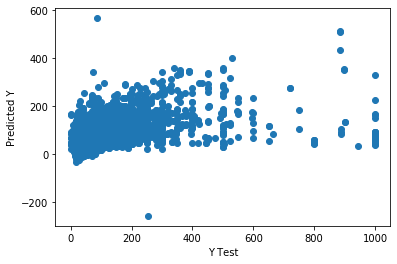

In [22]:
# Plot errors
plt.scatter(y_test, y_pred_lr)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_lr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))
print(r2_score(y_test, y_pred_lr))